In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../../../'))

from importlib import reload
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy


/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 648 results
transitions_data returned 212 results
total_population_data returned 648 results
initialization time:  80.2379949092865
simulation_time:  78.10091876983643
initialization time:  86.52136778831482
simulation_time:  76.37972927093506
initialization time:  82.14957404136658
simulation_time:  72.62433910369873


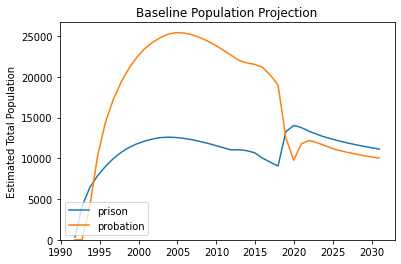

In [2]:
test_sim = SuperSimulationFactory.build_super_simulation('../../state/IL/IL_prison_EMPS_model_inputs.yaml')
test_sim.simulate_baseline(['prison', 'probation'])

initialization time:  80.59913802146912
simulation_time:  76.23169207572937
initialization time:  83.56846117973328
simulation_time:  73.36890387535095


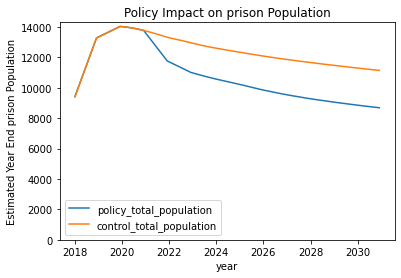

In [7]:
# DISAGGREGATION AXES
race = ['white', 'non-white']
crime_classification = ['drugs', 'residential burglary', 'second offense']

#SCENARIO
reallocation_fraction = 0.4

policy_list_non_retroactive = list()
policy_list_retroactive = list()

def apply_diversion(retroactive=False):
    return partial(ShellCompartment.reallocate_outflow, 
                   reallocation_fraction=reallocation_fraction,
                   outflow='prison',
                   new_outflow='probation'
                  )

for crime in crime_classification:
    for demo in race:
        policy_list_non_retroactive.append(SparkPolicy(
            policy_fn=apply_diversion(retroactive=False),
            spark_compartment='pretrial',
            sub_population={'crime_type': crime, 'race': demo},
            apply_retroactive=False
        ))
        policy_list_retroactive.append(SparkPolicy(
            policy_fn=apply_diversion(retroactive=False),
            spark_compartment='pretrial',
            sub_population={'crime_type': crime, 'race': demo},
            apply_retroactive=True
        ))
        
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [8]:
simulation_tag = 'IL_EMPS_40%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)